### Exploring Library of Congress dataset

--- 
Things to explore:

0. Basic statistics of the dataset
1. Are there any common words for each class? 
2. Common non-stop words in title/sypnosis
3. Any text cleaning that we should do?
4. Why some record title is not English and how many are theres
5. Comparising Length of sentences for each class

In [1]:
import sys
sys.path.append("../") 
# go to parent dir, a bit hacky but avoid having to put all the notebooks in root directory 😬

In [91]:
import time
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from collections import Counter
from iml_group_proj.features.simple import get_simple_features
from iml_group_proj.features.bert import get_BERT_features

from iml_group_proj.features.common.base import clean_text
from iml_group_proj.features.common.helper import remove_punc, sample_data, tokenize_words, truncate_words, concat_tokens, remove_punc, remove_stop_words, remove_empty_token

from iml_group_proj.models.mlp import BASIC_MLP
from iml_group_proj.evaluation import evaluate_many
from iml_group_proj.train_models import train_models
from iml_group_proj.features.common.data import load

from IPython.display import Image
from IPython.core.display import HTML 

In [7]:
classes, train, test = load("../trainTest.pk")

In [9]:
# To make things simplier, let's combine to one big dataframe
train["is_train"] = True
test["is_train"] = False
df = pd.concat([train, test], axis=0)
df = df[["class", "class_name", "title", "sypnosis", "id", "is_train"]]

In [10]:
df.head()

,class,class_name,title,sypnosis,id,is_train
18045,N,Fine Arts,The Usborne Introduction to art : in associati...,Detailed introduction to the history of art wi...,54799245,True
14931,T,Technology,Rockets /,"""An examination of the origins, history, devel...",62381342,True
3928,Q,Science,Scientists of Ancient Greece /,Discusses the life and work of the seven Greek...,38886648,True
1678,B,Philosophy. Psychology. Religion,Kontroversi Aswaja : aula perdebatan dan reint...,Islamic theology; criticism and interpretation...,45846525,True
23358,F,History of the Americas (F),The Great Chicago Fire /,"Discusses the 1871 Chicago fire, its causes, t...",57652528,True


### 0) Are the class really balanced?

In [27]:
tmp = df[["class_name", "is_train"]].value_counts().reset_index()
tmp.pivot(index="class_name", columns="is_train")

0      
is_train                                           False  True
class_name                                                    
Agriculture                                          200  1056
Education                                            200  1800
Fine Arts                                            200  1782
Geography. Anthropology. Recreation                  200  1800
History of the Americas (E)                          200  1800
History of the Americas (F)                          200  1800
Language and Literature                              200  1800
Law                                                  200  1345
Medicine                                             200  1800
Philosophy. Psychology. Religion                     200  1800
Political Science                                    200  1543
Science                                              200  1800
Social Sciences                                      200  1800
Technology                                           200  1800
World History and History of Europe, Asia, Afri...   200  1800

In [12]:
Image(url= "https://www.meme-arsenal.com/memes/e837e8811c81b0346c20fec1af8ea93d.jpg",width=300)

### 1. Explore common words in each class

In [39]:
# Cleaning data
cleaning_pipelines = [
    remove_punc,
    tokenize_words,
    remove_stop_words,
    remove_empty_token
]

In [46]:
df["title_words"] = clean_text(df.title, cleaning_pipelines)
df["sypnosis_words"] = clean_text(df.sypnosis, cleaning_pipelines)

In [48]:
word_counts = df.groupby("class_name").agg({"title_words": sum, "sypnosis_words": sum})

In [76]:
title_counts = word_counts["title_words"].apply(lambda word_counts: Counter(word_counts))
result = pd.DataFrame(title_counts.apply(lambda x: x.most_common(20)))[:-1]

result

,title_words
class_name,
Agriculture,"[(The, 130), (dan, 68), (book, 53), (di, 47), (dog, 41), (farm, 41), (dogs, 41), (A, 37), (story, 36), (guide, 35), (garden, 34), (life, 28), (horses, 28), (true, 27), (horse, 26), (My, 24), (animals, 22), (cat, 21), (Indonesia, 21), (hutan, 21)]"
Education,"[(The, 190), (education, 136), (learning, 116), (pendidikan, 116), (guide, 116), (school, 107), (dan, 93), (activities, 88), (reading, 80), (teachers, 72), (students, 68), (writing, 68), (classroom, 67), (A, 61), (skills, 59), (di, 57), (children, 54), (teaching, 54), (book, 52), (Teaching, 51)]"
Fine Arts,"[(art, 302), (The, 258), (Art, 81), (artists, 61), (book, 60), (dan, 56), (American, 52), (A, 52), (architecture, 51), (seni, 50), (de, 49), (guide, 40), (Indonesia, 40), (life, 39), (history, 38), (artist, 38), (world, 35), (di, 31), (arts, 31), (draw, 30)]"
Geography. Anthropology. Recreation,"[(The, 236), (world, 96), (history, 68), (dan, 66), (book, 64), (sports, 56), (baseball, 51), (guide, 51), (story, 48), (games, 44), (A, 38), (di, 37), (Christmas, 36), (I, 34), (geography, 29), (around, 28), (game, 27), (life, 27), (masyarakat, 26), (America, 24)]"
History of the Americas (E),"[(The, 476), (American, 252), (America, 141), (War, 127), (history, 121), (Civil, 92), (story, 84), (Americans, 83), (States, 70), (Indian, 69), (United, 68), (Native, 65), (Indians, 61), (life, 56), (Black, 50), (Americas, 49), (A, 48), (freedom, 42), (John, 42), (King, 41)]"
History of the Americas (F),"[(The, 316), (de, 181), (America, 92), (Mexico, 90), (la, 88), (history, 81), (Ohio, 71), (American, 68), (A, 64), (New, 58), (story, 53), (en, 53), (West, 52), (alphabet, 44), (life, 42), (los, 41), (Lewis, 40), (Clark, 40), (County, 40), (del, 39)]"
Language and Literature,"[(The, 428), (novel, 86), (A, 68), (mystery, 46), (stories, 43), (story, 34), (I, 34), (Little, 30), (book, 30), (poems, 27), (Christmas, 25), (tale, 25), (dan, 23), (bahasa, 19), (little, 19), (night, 17), (My, 17), (love, 16), (How, 15), (man, 14)]"
Law,"[(dan, 207), (The, 189), (law, 145), (hukum, 124), (di, 123), (Indonesia, 101), (Islam, 77), (dalam, 76), (rights, 67), (tahun, 52), (undangundang, 47), (Court, 47), (laws, 43), (justice, 43), (trial, 42), (Malaysia, 42), (case, 42), (Akta, 40), (A, 39), (United, 37)]"
Medicine,"[(health, 193), (The, 184), (guide, 115), (disorders, 92), (medicine, 71), (medical, 68), (information, 67), (AIDS, 67), (care, 62), (story, 57), (disease, 53), (dan, 47), (children, 44), (A, 44), (book, 43), (Health, 43), (life, 39), (nursing, 38), (diseases, 36), (drugs, 35)]"


In [77]:
title_counts = word_counts["sypnosis_words"].apply(lambda word_counts: Counter(word_counts))
result = pd.DataFrame(title_counts.apply(lambda x: x.most_common(20)))[:-1]

result

,sypnosis_words
class_name,
Agriculture,"[(The, 176), (care, 157), (Describes, 151), (life, 139), (history, 128), (information, 118), (A, 118), (text, 116), (photographs, 113), (including, 107), (dogs, 107), (animals, 103), (This, 92), (behavior, 86), (Discusses, 84), (dog, 81), (development, 80), (forest, 78), (farm, 77), (different, 76)]"
Education,"[(students, 693), (education, 531), (The, 513), (school, 460), (teachers, 431), (book, 405), (learning, 385), (This, 378), (activities, 320), (children, 317), (reading, 301), (schools, 244), (skills, 234), (teaching, 223), (research, 212), (classroom, 211), (information, 205), (A, 191), (help, 191), (teacher, 189)]"
Fine Arts,"[(art, 765), (artists, 415), (The, 345), (work, 308), (life, 303), (works, 247), (artist, 245), (book, 243), (paintings, 226), (A, 220), (American, 199), (This, 178), (history, 173), (painting, 160), (architecture, 145), (world, 138), (Art, 132), (painter, 130), (information, 129), (collection, 125)]"
Geography. Anthropology. Recreation,"[(history, 317), (The, 272), (A, 261), (world, 243), (life, 206), (Describes, 195), (This, 182), (book, 178), (including, 175), (baseball, 166), (games, 132), (information, 130), (publisher, 130), (people, 130), (sports, 124), (American, 119), (first, 115), (one, 107), (game, 99), (Discusses, 99)]"
History of the Americas (E),"[(American, 718), (life, 540), (history, 506), (The, 393), (A, 385), (United, 304), (War, 298), (States, 297), (people, 258), (Americans, 258), (America, 230), (political, 210), (first, 208), (Indian, 201), (This, 189), (book, 188), (biography, 171), (events, 170), (Civil, 169), (Native, 169)]"
History of the Americas (F),"[(history, 750), (American, 641), (Latin, 463), (people, 419), (Studies, 419), (v, 418), (geography, 328), (life, 319), (The, 283), (A, 273), (culture, 255), (economy, 221), (57, 216), (de, 206), (58, 200), (government, 175), (An, 167), (Describes, 159), (political, 146), (state, 141)]"
Language and Literature,"[(A, 458), (The, 405), (life, 199), (In, 196), (When, 166), (one, 164), (family, 161), (new, 153), (young, 143), (author, 132), (man, 118), (mother, 113), (father, 108), (girl, 106), (woman, 106), (boy, 105), (find, 104), (friends, 99), (story, 98), (school, 98)]"
Law,"[(law, 556), (legal, 298), (The, 254), (Court, 203), (Indonesia, 196), (Indonesian, 188), (rights, 175), (This, 170), (Supreme, 169), (cases, 166), (laws, 155), (Islamic, 137), (issues, 134), (information, 131), (Constitution, 129), (United, 126), (history, 125), (American, 123), (book, 117), (States, 115)]"
Medicine,"[(health, 583), (The, 526), (information, 445), (treatment, 294), (medical, 292), (book, 284), (This, 280), (disease, 271), (A, 231), (disorders, 223), (care, 201), (Discusses, 197), (medicine, 190), (research, 182), (including, 176), (diseases, 160), (publisher, 159), (use, 158), (effects, 154), (people, 151)]"


### Record's title that aren't English

In [87]:
# Seems like lots of title from Political Science aren't English, their sypnosis are though.
df[["title", "sypnosis"]][df.class_name =="Political Science"].sample(10)

,title,sypnosis
415,Memori masa bhakti /,"End-of-office report of former President Habibie's cabinet, May 1998-Oct. 1999."
24157,Scenarios for the insurgency in Iraq /,"Touching on a top U.S. foreign policy priority, this Special Report identifies several possibly outcomes of the insurgency in Iraq, and recommends to U.S. policymakers the best strategies to deal with the current situation and the unfolding futures."
1049,Brazilian industrialists and democratic change /,"""Important study of business elites and their attitudes toward democratization in 1980s is based heavily on personal interviews with leading industrialists. Finds that many of the incentives that led these actors to support the coup of 1964 have changed or disappeared. Offers a worthwhile glimpse into the thinking of these elites""--Handbook of Latin American Studies, v. 57."
15289,Menuju partai masa depan : pemikiran dan gagasan tentang PPP /,Collection of opinions and concepts on Partai Persatuan Pembangunan.
2121,Kekuasaan presiden dalam UUD 1945 sangat besar /,The executive power of the president according to the 1945 Constitution.
1149,Dasar awam di Malaysia /,Public administration in Malaysia.
12976,"Wira bangsa dalam kenangan : sejarah perjuangan UMNO & profil ahli majlis kerja tertinggi, 1946-2000.",History and profile of UMNO Supreme Council members from 1946 to 2000.
10683,1996 tahun kekerasan : potret pelanggaran HAM di Indonesia.,"Human and civil rights abuse in Indonesia, 1996; report."
12378,Manajemen otonomi daerah : membangun daerah berdasar paradigma baru /,Study of regional autonomy in Indonesia.
7538,Menentang arogansi kekuasaan : kasus Mega Bintang /,"Indonesian politics leading up to the 1997 elections, and the alliance between PDI Perjuangan and PPP; research report."


### Comparing sentences length of each class

<AxesSubplot:xlabel='title_words_count', ylabel='class_name'>

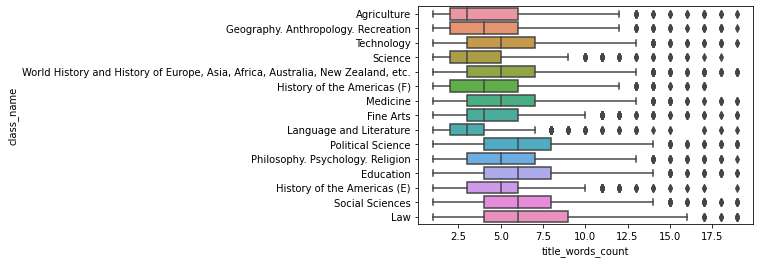

In [105]:
df["title_words_count"] = df.title_words.apply(len)
df_ = df[df.title_words_count < 20].sort_values("title_words_count")
sns.boxplot(data=df_.reset_index(), x="title_words_count", y="class_name")

<AxesSubplot:xlabel='sypnosis_words_count', ylabel='class_name'>

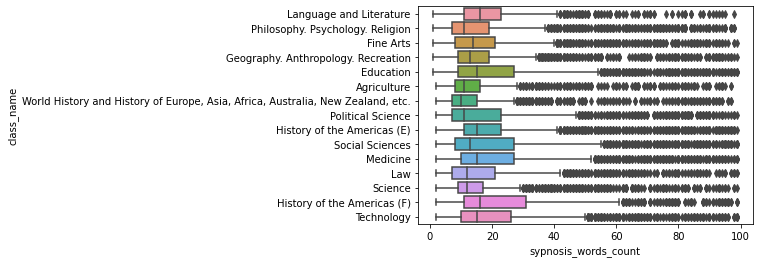

In [112]:
df["sypnosis_words_count"] = df.sypnosis_words.apply(len)
df_ = df[df.sypnosis_words_count < 100].sort_values("sypnosis_words_count")
sns.boxplot(data=df_.reset_index(), x="sypnosis_words_count", y="class_name")